## Загрузка и первичный анализ данных
Для выполнения задания был выбран датасет библиотеки sklearn с данными о характеристиках вин и их рейтингом цен.

https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20datasets#module-sklearn.datasets

In [50]:
from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from operator import itemgetter
import pydotplus
import graphviz
from gmdhpy import gmdh
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from IPython.display import Image
from io import StringIO
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.datasets import *
%matplotlib inline
sns.set(style="ticks")

In [4]:
ds = load_wine()
data = pd.DataFrame(data= np.c_[ds['data'], ds['target']],
                 columns= list(ds['feature_names']) + ['class'])
data.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
class                           float64
dtype: object

In [3]:
data.shape

(178, 14)

In [4]:
data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [5]:
np.unique(data['class'])

array([0., 1., 2.])

In [6]:
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

В датасете нет пропусков

Будем решать задачу классификации. Поскольку в датасете имеется большое количество столблов с небинарными данными, то мы будем использовать сетрики для оценки моделей с небинарными данными. Для оценки обученных моделей планируется использование метрики accuracy, Confusion matrix. Предварительно проверим, можно ли применить их.

In [7]:
np.unique(data['class'], return_counts=True)

(array([0., 1., 2.]), array([59, 71, 48], dtype=int64))

Классы сбалансированы. Можно использовать метрику accuracy.

Корелляционная матрица

In [8]:
data.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115,-0.719163
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193,-0.847498
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100,0.265668


## Разделение выборки на обучающую и тестовую.

In [5]:
y=np.array(data["class"])
X=np.array(data.drop(["class"], axis=1))
X, y

(array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

Разделение выборки на обучающую и тестовую

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,shuffle=True)

Выборка разделена на обучающую X_train, y_train и тестовую X_test, y_test

## Обучение ансамблевых моделей

### Случайный лес

In [52]:
# Обучим классификатор на 5 деревьях
RFC = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)
RFChamming = hamming_loss(y_test, y_pred)
RFCacc = accuracy_score(y_test, y_pred)

y_pred

C:\Users\Alexandra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


array([2., 1., 0., 1., 0., 2., 1., 0., 2., 1., 0., 0., 1., 0., 1., 1., 2.,
       0., 1., 0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 2., 1., 2., 2., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 2., 0.])

In [8]:
# Out-of-bag error, возвращаемый классификатором
RFC.oob_score_, 1-RFC.oob_score_

(0.8306451612903226, 0.16935483870967738)

In [9]:
RFC.oob_decision_function_[55:70]

array([[0.5       , 0.5       , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.25      , 0.75      , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333]])

In [10]:
tree_y = RFC.predict(X_test)
tree_y

array([2., 1., 0., 1., 0., 2., 1., 0., 2., 1., 0., 0., 1., 0., 1., 1., 2.,
       0., 1., 0., 0., 1., 2., 1., 0., 2., 0., 0., 0., 2., 1., 2., 2., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 2., 0.])

### Градиентный бустинг

In [11]:
GBC = GradientBoostingClassifier(random_state=1)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

In [53]:
y_pred = GBC.predict(X_test)
GBChamming = hamming_loss(y_test, y_pred)
GBCacc = accuracy_score(y_test, y_pred)
y_pred

array([2., 1., 0., 1., 0., 2., 1., 0., 2., 1., 0., 0., 1., 0., 1., 1., 2.,
       0., 1., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 2., 1., 2., 2., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1.,
       2., 2., 0.])

### Стэкинг

In [48]:
# Набор данных
dataset = Dataset(X_train, y_train, X_test)

# модели первого уровня
model_dt = Classifier(dataset=dataset, estimator=DecisionTreeClassifier, name='dt', probability =False)
model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 15, 'oob_score':True, 'random_state':0},name='rf', probability =False)

# модель второго уровня
pipeline = ModelsPipeline(model_rf, model_lr)
stack_ds = pipeline.stack(k=15, seed=111)

stacker = Classifier(dataset=stack_ds, estimator=RandomForestClassifier, parameters={'n_estimators': 15, 'oob_score':True, 'random_state':0}, probability =False)
stacker_y = stacker.predict()
stacker_y

results = stacker.validate(k=10,scorer=accuracy_score)

Metric: accuracy_score
Folds accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 1.0]
Mean accuracy: 0.9833333333333332
Standard Deviation: 0.03333333333333335
Variance: 0.001111111111111112


In [49]:
results2 = stacker.validate(k=10,scorer=hamming_loss)

Metric: hamming_loss
Folds accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.08333333333333333, 0.0]
Mean accuracy: 0.016666666666666666
Standard Deviation: 0.03333333333333333
Variance: 0.0011111111111111111


### Модель многослойного персептрона

In [17]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=1)

In [54]:
predMLPC = mlp.predict(X_test)
MLPChamming = hamming_loss(y_test, predMLPC)
MLPCacc = accuracy_score(y_test, predMLPC)

predMLPC

array([2., 1., 2., 2., 0., 2., 2., 0., 2., 2., 0., 2., 1., 0., 2., 2., 1.,
       2., 1., 0., 0., 1., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 0.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 2.,
       2., 2., 0.])

In [20]:
acc = []
acc_tr = []
for l in [5,10,15,25,50,75,100]:
    mlp = MLPClassifier(alpha=0.1, max_iter=200, hidden_layer_sizes=(l,))
    mlp.fit(X_train, y_train)
        
    a_tr = accuracy_score(y_train, mlp.predict(X_train)) # Train Accuracy
    a = accuracy_score(y_test, mlp.predict(X_test)) # Test Accuracy

    acc_tr.append(a_tr)
    acc.append(a)

C:\Users\Alexandra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alexandra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


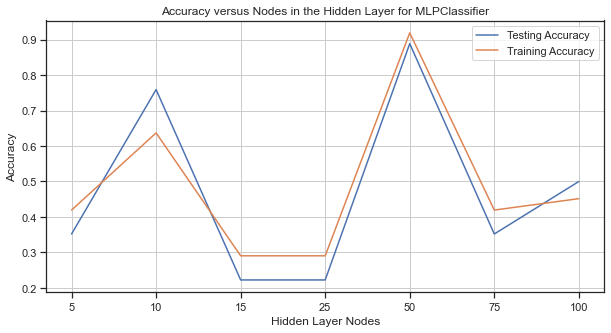

In [22]:
l = [5,10,15,25,50,75,100]
N = len(l)
l2 = np.arange(N)
plt.subplots(figsize=(10, 5))
plt.plot(l2, acc, label="Testing Accuracy")
plt.plot(l2, acc_tr, label="Training Accuracy")
plt.xticks(l2,l)
plt.grid(True)
plt.xlabel("Hidden Layer Nodes")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus Nodes in the Hidden Layer for MLPClassifier', fontsize=12)
plt.show()

### Модель МГУА

Модель обучается только на бинарных данных. Построить модель для выбранных в задаче данных невозможно.

Преобразуем целевой признак в бинарный

In [61]:
data_gmdh = data.copy()

In [63]:
data_gmdh['class'] = data_gmdh['class'].replace(to_replace=2, value=1)

In [64]:
y_bin=np.array(data_gmdh["class"])
X_bin=np.array(data_gmdh.drop(["class"], axis=1))
X_bin, y_bin

(array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [65]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.3, random_state=1,shuffle=True)

In [73]:
pd.to_numeric(y_train_bin, downcast='integer')
pd.to_numeric(y_test_bin, downcast='integer')

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0], dtype=int8)

In [80]:
gmdh_model = gmdh.Classifier()
gmdh_model.fit(X_train_bin, y_train_bin)
y_predict_proba = gmdh_model.predict_proba(X_test_bin)
y_predict_proba

train layer0 in 0.41 sec
train layer1 in 1.93 sec
train layer2 in 1.78 sec
train layer3 in 1.90 sec
train layer4 in 1.81 sec
train layer5 in 1.80 sec
train layer6 in 1.84 sec
train layer7 in 1.77 sec
train layer8 in 1.88 sec
train layer9 in 2.03 sec
train layer10 in 2.04 sec


array([0.96062349, 0.96143757, 0.06571846, 0.9610195 , 0.06548376,
       0.96095141, 0.96151702, 0.0653881 , 0.96150524, 0.96133918,
       0.06545429, 0.2367882 , 0.96149067, 0.0654405 , 0.9615058 ,
       0.96158441, 0.96122859, 0.06565336, 0.96145834, 0.06551902,
       0.06546149, 0.96128709, 0.96132384, 0.0662857 , 0.06600023,
       0.96136097, 0.06544975, 0.06549782, 0.06540604, 0.96135196,
       0.96142387, 0.96087627, 0.96136571, 0.06540389, 0.96134558,
       0.96155597, 0.96155273, 0.9567755 , 0.96149251, 0.06546319,
       0.06549679, 0.96151252, 0.96066123, 0.06565067, 0.06542264,
       0.0666334 , 0.96127478, 0.06549153, 0.06539904, 0.06547318,
       0.96153114, 0.95932965, 0.96108316, 0.06549146])

In [81]:
y_pred = []
for y in y_predict_proba:
    if y >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred

[1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0]

In [82]:
GMDHhamming = hamming_loss(y_test_bin, y_pred)
GMDHacc = accuracy_score(y_test_bin, y_pred)

### Оценки моделей

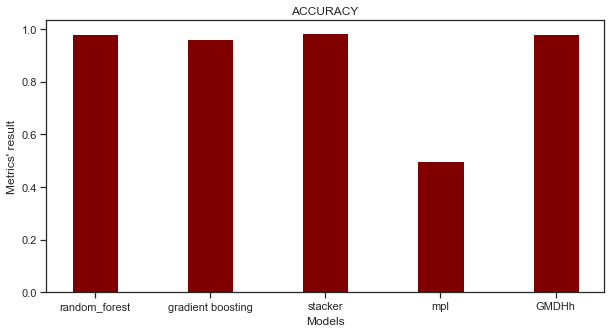

In [83]:
metric_acc = [RFCacc, GBCacc, 0.9833333333333332, MLPCacc, GMDHacc]
metric_hamming = [RFChamming, GBChamming, 0.016666666666666666, MLPChamming, GMDHhamming]
model_list = ['random_forest', 'gradient boosting', 'stacker', 'mpl','GMDHh']
fig = plt.figure(figsize = (10, 5))
 
# accuracy
plt.bar(model_list, metric_acc, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Metrics' result")
plt.title("ACCURACY")
plt.show()

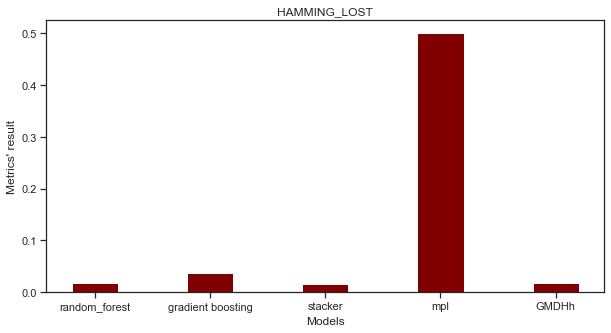

In [84]:
# hamming_lost

fig = plt.figure(figsize = (10, 5))
 
# accuracy
plt.bar(model_list, metric_hamming, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Metrics' result")
plt.title("HAMMING_LOST")
plt.show()

По результатам оценок обеих метрик модель "Стэкинга" даст лучшее предсказание классификации.